In [1]:
!pip install xarray pooch # for the dataset
!pip install torch # for defining the model
!pip install deephyper # for HPO
!pip install nvidia-physicsnemo # for FNO

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Hyperparameters
Hyperparameters are non-trainable parameters determining the networks capacity and structure as well as data preprocessing and training strategies. For example, in the previous tutorials, the number of FNO blocks, number of Fourier modes, number of hidden dimension in the lift and projection operations are hyperparameters, largely affect the network performance.

## Explore the impact of hyperparameters
Feel free to adjust all the hyparameters defininng the training process and network architectures.

# Load and process the data
The first thing to do is to identify the task and dataset, we will use the SST data from xarray and perform pixel regression tasks


In [2]:
from physicsnemo.models.fno import FNO
import matplotlib.pyplot as plt
import xarray as xr
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# load and prepare the data
ds = xr.tutorial.open_dataset('ersstv5')
sst = ds['sst']


dummy_value = 0.0
# sst = sst.fillna(dummy_value)  


# shape = (T, H, W)
data = sst.values.astype('float32')
T, H, W = data.shape

# 2. Define sliding‐window parameters
T_in   = 1                     # number of input time steps
T_pred = 1              # number of steps to predict
step   = 1                       # sliding window stride
# total number of (input, target) pairs
n_samples = (T - (T_in + T_pred)) // step + 1

# 3. Build arrays of shape (n_samples, H, W, T_in) and (n_samples, H, W, T_pred)
X = np.zeros((n_samples, T_in, H, W),  dtype='float32')
Y = np.zeros((n_samples, T_pred, H, W), dtype='float32')

for i in range(n_samples):
    start = i * step
    X[i] = data[start : start + T_in]
    Y[i] = data[start + T_in : start + T_in + T_pred]
    
# land masks
x_mask_land = np.isnan(X[0])
y_mask_land = np.isnan(Y[0])

# fill nans
X[:,x_mask_land] = dummy_value
Y[:,x_mask_land] = dummy_value

print("Data shapes are", X.shape, Y.shape)


# 5. Split into train / eval / test
ntrain = int(0.8 * n_samples)
neval  = int(0.2 * ntrain)
ntest  = n_samples - ntrain

# train
train_X = torch.from_numpy(X[:ntrain])
train_Y = torch.from_numpy(Y[:ntrain])
# eval (from end of train split)
eval_X = torch.from_numpy(X[ntrain : ntrain+neval])
eval_Y = torch.from_numpy(Y[ntrain : ntrain+neval])
# test (the remainder)
test_X = torch.from_numpy(X[ntrain+neval :])
test_Y = torch.from_numpy(Y[ntrain+neval :])


# 6. Create DataLoaders
batch_size = 10

train_loader = DataLoader(TensorDataset(train_X, train_Y),
                          batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(TensorDataset(eval_X,  eval_Y),
                          batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(test_X,  test_Y),
                          batch_size=batch_size, shuffle=False)




Using device cuda
Data shapes are (623, 1, 89, 180) (623, 1, 89, 180)


# Train a model and adjust hyperparameters

Training...: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Final validation loss is 24.5780


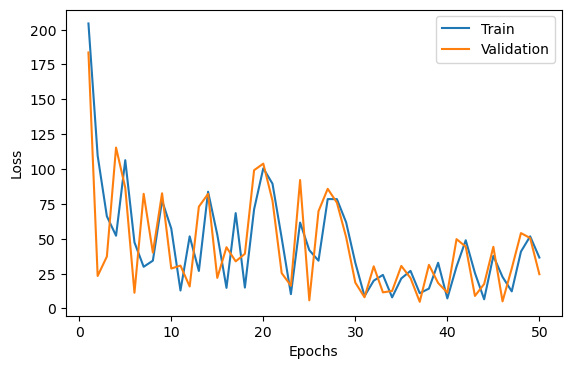

In [3]:
# initialize the model
model = FNO(in_channels=1, out_channels=1, num_fno_modes=6, dimension=2) 
model.to(device)

# start traning
EPOCHS = 50
LR = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# ocean masks
x_mask = torch.tensor(~x_mask_land, device=device)
y_mask = torch.tensor(~y_mask_land, device=device)

torch.manual_seed(0)

train_stats = {"train_loss": [], "val_loss": []}
for epoch in tqdm(range(EPOCHS), desc="Training..."):
    model.train()
    running_train_ls = 0
    for x, y in train_loader:
        # send to device and zero out land areas
        x = x.to(device) * x_mask
        y = y.to(device) * y_mask
        y_pred = model(x) * y_mask
        assert y_pred.shape == y.shape, f"shape mismatch, y_pred shape {y_pred.shape}"
        train_loss = torch.nn.functional.mse_loss(y, y_pred)
        train_loss.backward()
        optimizer.step()
        running_train_ls += train_loss.item()

    model.eval()
    running_val_ls = 0
    for x_val, y_val in eval_loader:
        x_val = x_val.to(device) * x_mask
        y_val = y_val.to(device) * y_mask
        y_pred_val = model(x_val) * y_mask
        val_loss = torch.nn.functional.mse_loss(y_val, y_pred_val)
        running_val_ls += val_loss.item()

    train_stats["train_loss"].append(running_train_ls / len(train_loader))
    train_stats["val_loss"].append(running_val_ls/ len(eval_loader))
        
# visualize learning curves
fig, ax = plt.subplots()
ax.set_box_aspect(1/1.62)
ax.plot(np.arange(1,  EPOCHS+1), train_stats["train_loss"], label="Train")
ax.plot(np.arange(1, EPOCHS+1), train_stats["val_loss"], label="Validation")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

print(f"Final validation loss is {train_stats['val_loss'][-1]:.4f}")

Text(0.5, 1.0, 'Predicted')

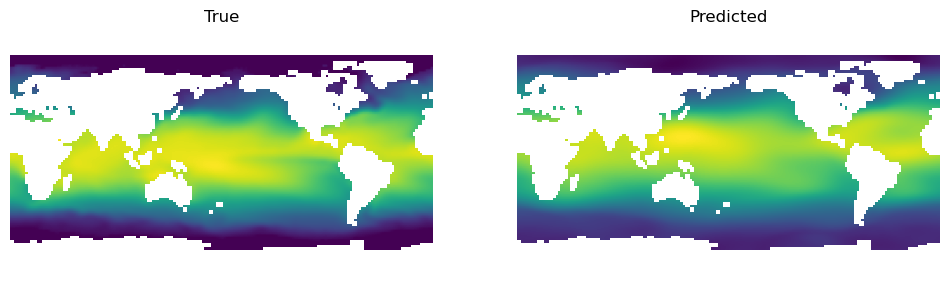

In [4]:
# visualize baseline prediction
model.eval()
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.to(device), y_test.to(device)
x_test = x_test * x_mask
y_pred = model(x_test) * y_mask


plot_mask = y_mask.detach().cpu().numpy()
plot_mask = plot_mask.astype(bool)



y_true = y_test.detach().cpu().numpy()[0]
y_pred = y_pred.detach().cpu().numpy()[0]
y_true[~plot_mask] = np.nan
y_pred[~plot_mask] = np.nan

fig, ax = plt.subplots(1,2, figsize=(12,6))
for a in ax:
    a.set_box_aspect(1/1.62)
    a.axis('off')
ax[0].imshow(y_true.squeeze())
ax[0].set_title("True")
ax[1].imshow(y_pred.squeeze())
ax[1].set_title("Predicted")

# Hyperparameter search
It is natural to ask the quetion: how can we find the best set of hyperparameters that it can lead to the best performing model for the task?

We can:
- Exhaust all the combination of hyperparameters and conduct evaluation and pick out the best performing one.
- Randomly select a few sets of hyparameters and do the evaluation and return the best performing one.
- Determine the most influential subset of hyperparameters that much smaller than the entire set and perform the search.

**Is there a better and more efficient way?**
- Genetic algorithm
- Bayesian optimization
- ...

We will breifly discuss how Bayesian optimization can help with the task and the types of surrogates we can use for this task.

## Bayesian optimization (BO) with DeepHyper
BO is a global black-box function optimization method where we build probablistic models of the function and iteratively evaluation promising function inputs based on the current model.

With this
- hyperparameters as the input
- model evaluation metrics as the output (e.g., validation loss)

<u>DeepHyper</u> provides efficient and scalable BO framework for hyperparameter search in deep learning models.

To perform hyperparameter search in DeepHyper, we need
- a learning tasks and training and validation datasets
- a hyperparameter search space where an element of the space determines a neural network and its training process
- a run function that takes as input the hyperparameters and outputs the objective
- an evalulation to excute the search with pre-defined parameters

In [5]:
# some deephyper imports
# briefly explain each API
from deephyper.hpo import HpProblem
from deephyper.evaluator import Evaluator
from deephyper.hpo import CBO
from deephyper.evaluator import RunningJob, profile # optional

# Define the hyperparameter search space
Hyperparameter ranges are defined using the following syntax:

- Discrete integer ranges are generated from a tuple (lower: `int`, upper:`int`); e.g., number of layers, number of neurons per layer, and number of traning steps, etc.

- Continuous prarameters are generated from a tuple (lower: `float`, upper: `float`); e.g., learning rate, weight decay, drop out rate, etc.

- Categorical or nonordinal hyperparameter ranges can be given as a list of possible values `[val1, val2, ...]`; e.g., types of activation functions, data normalization strategies, etc.

We provide the default configuration of hyperparameters as a starting point of the problem

In [6]:
# define the hpproblem
problem = HpProblem()
activations = [
    "relu",
    "leaky_relu",
    "prelu",
    "relu6",
    "elu",
    "selu",
    "silu",
    "gelu",
    "sigmoid",
    "logsigmoid",
    "softplus",
    "softshrink",
    "softsign",
    "tanh",
    "tanhshrink",
    "threshold",
    "hardtanh",
    "identity",
    "squareplus",
]
optimizers = ["Adadelta", "Adagrad", "Adam", "AdamW", "RMSprop", "SGD"]

problem.add_hyperparameter((1, 16), "padding", default_value=8)
problem.add_hyperparameter(
    ["constant", "reflect", "replicate", "circular"],
    "padding_type",
    default_value="constant",
)
problem.add_hyperparameter([True, False], "coord_feat", default_value=True)
problem.add_hyperparameter(activations, "lift_act", default_value="gelu")
problem.add_hyperparameter((2, 32), "num_FNO", default_value=4)
problem.add_hyperparameter((2, 32), "num_modes", default_value=3)
problem.add_hyperparameter((2, 64), "latent_ch", default_value=32)
problem.add_hyperparameter((1, 16), "num_projs", default_value=1)
problem.add_hyperparameter((2, 32), "proj_size", default_value=32)
problem.add_hyperparameter(activations, "proj_act", default_value="silu")

# problem.add_hyperparameter(optimizers, "optimizer", default_value="Adam")
problem.add_hyperparameter(
    (1e-6, 1e-2, "log-uniform"), "lr", default_value=1e-3
)
problem.add_hyperparameter((0.0, 0.1), "weight_decay", default_value=0)

UniformFloatHyperparameter(name='weight_decay', default_value=0.0, meta=None, size=inf, lower=0.0, upper=0.1, log=False)

# Define the `run` function
In Deephyper, the `run` function takes a `RunningJob` as the input and output the objective or a dictionary containing the objective and optional meta data. The `run` function can be regarded as the black-box function evaluation step in the optimization process. The training loop can be defined inside or outside the run function.

In [7]:
from types import SimpleNamespace

@profile
def run(job: RunningJob):
    config = job.parameters
    config = SimpleNamespace(**config)
    model = FNO(
        in_channels=1,
        out_channels=1,
        decoder_layers=config.num_projs,
        decoder_layer_size=config.proj_size,
        decoder_activation_fn=config.proj_act,
        dimension=2,
        latent_channels=config.latent_ch,
        num_fno_layers=config.num_FNO,
        num_fno_modes=int(config.num_modes),
        padding=config.padding,
        padding_type=config.padding_type,
        activation_fn=config.lift_act,
        coord_features=config.coord_feat,
    ).to(device)

    # start traning
    EPOCHS = 2
    LR = config.lr
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=config.weight_decay)

    train_stats = {"train_loss": [], "val_loss": []}
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        running_train_ls = 0
        for x, y in train_loader:
            # send to device and zero out land areas
            x = x.to(device) * x_mask
            y = y.to(device) * y_mask
            y_pred = model(x) * y_mask
            assert y_pred.shape == y.shape, f"shape mismatch, y_pred shape {y_pred.shape}"
            train_loss = torch.nn.functional.mse_loss(y, y_pred)
            train_loss.backward()
            optimizer.step()
            running_train_ls += train_loss.item()
    
        model.eval()
        running_val_ls = 0
        for x_val, y_val in eval_loader:
            x_val = x_val.to(device) * x_mask
            y_val = y_val.to(device) * y_mask
            y_pred_val = model(x_val) * y_mask
            val_loss = torch.nn.functional.mse_loss(y_val, y_pred_val)
            running_val_ls += val_loss.item()
    
        train_stats["train_loss"].append(running_train_ls / len(train_loader))
        train_stats["val_loss"].append(running_val_ls/ len(eval_loader))
        obj = -float(train_stats["val_loss"][-1])
    return {"objective": obj, "metadata":{"train_loss": train_stats["train_loss"], "validation_loss": train_stats["val_loss"]}}

In [8]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


# define the evaluator to distribute the computation
evaluator = Evaluator.create(
    run,
    method="thread",
)

/global/homes/y/yixuans/.local/perlmutter/python-3.11/lib/python3.11/site-packages/deephyper/evaluator/_evaluator.py:128: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn("Applying nest-asyncio patch for IPython Shell!", category=UserWarning)


# Execute the search with Centralized BO

In [9]:
from deephyper.hpo import CBO
search = CBO(problem, evaluator, verbose=1,
        initial_points=[problem.default_configuration], random_state=0)
reuslts = search.search(max_evals=20)

100%|██████████| 2/2 [00:10<00:00,  5.16s/it]


# Inspect the search reults and return the optimial hyperparameters
DeepHyper offers utilities to conduct simple visualization of the search trajectories to check if the search has been effective. During the search process, we expect to see improvement on the search objective. After the search, we can finally return the optimial configuration and optionally retrain the model 

In [11]:
reuslts

,p:coord_feat,p:latent_ch,p:lift_act,p:lr,p:num_FNO,p:num_modes,p:num_projs,p:padding,p:padding_type,p:proj_act,...,p:weight_decay,objective,job_id,job_status,m:timestamp_submit,m:timestamp_start,m:timestamp_end,m:train_loss,m:validation_loss,m:timestamp_gather
0,True,32,gelu,0.001000,4,3,1,8,constant,silu,...,0.000000,-1.867058e+02,0,DONE,2.929951,1.746809e+09,1.746809e+09,"[150.25068241119385, 192.06456817626952]","[168.52516174316406, 186.70575561523438]",4.239731
1,False,47,softplus,0.000004,19,31,5,8,constant,gelu,...,0.055522,-2.287561e+02,1,DONE,4.307541,1.746809e+09,1.746809e+09,"[221.8232177734375, 221.43663452148436]","[229.1418884277344, 228.7561264038086]",16.233255
2,True,21,leaky_relu,0.009849,30,6,14,12,reflect,elu,...,0.051196,-3.937417e+31,2,DONE,16.291107,1.746809e+09,1.746809e+09,"[1811042.3289030457, 1.3861273131888073e+31]","[23493804.6, 3.937417452214776e+31]",22.807562
3,True,59,tanh,0.000008,27,12,4,12,constant,sigmoid,...,0.034962,-2.297022e+02,3,DONE,22.864684,1.746809e+09,1.746809e+09,"[222.66714172363282, 222.35352813720704]","[230.05922241210936, 229.70217895507812]",36.954957
4,True,60,prelu,0.003574,11,28,11,2,reflect,softplus,...,0.040343,-2.308533e+02,4,DONE,37.012975,1.746809e+09,1.746809e+09,"[425.328690032959, 6638.34084854126]","[192.53429718017577, 230.85333557128905]",44.778950
5,True,5,identity,0.001127,22,30,10,10,constant,elu,...,0.067900,-1.318643e+02,5,DONE,44.840148,1.746809e+09,1.746809e+09,"[152.81301132202148, 125.61901290893555]","[141.57061309814452, 131.86425323486327]",49.219699
6,False,9,threshold,0.002866,14,16,13,11,reflect,gelu,...,0.028337,-1.774708e+02,6,DONE,49.271943,1.746809e+09,1.746809e+09,"[192.79177139282226, 179.72696350097655]","[152.94239044189453, 177.47083892822266]",52.976667
7,False,56,sigmoid,0.000002,22,8,10,12,replicate,softshrink,...,0.068070,-2.282947e+02,7,DONE,53.038206,1.746809e+09,1.746809e+09,"[220.79130645751954, 220.79438537597656]","[228.29687957763673, 228.29470520019532]",62.293781
8,True,17,gelu,0.004725,4,31,8,9,circular,hardtanh,...,0.082033,-1.173799e+02,8,DONE,62.349508,1.746809e+09,1.746809e+09,"[114.94084289550781, 100.65126602172852]","[93.54410095214844, 117.37993774414062]",63.939976
9,True,51,threshold,0.001440,27,31,7,13,constant,relu6,...,0.077981,-1.171407e+02,9,DONE,63.995789,1.746809e+09,1.746809e+09,"[184.09650299072266, 121.72215454101563]","[140.51263732910155, 117.14065551757812]",82.369566


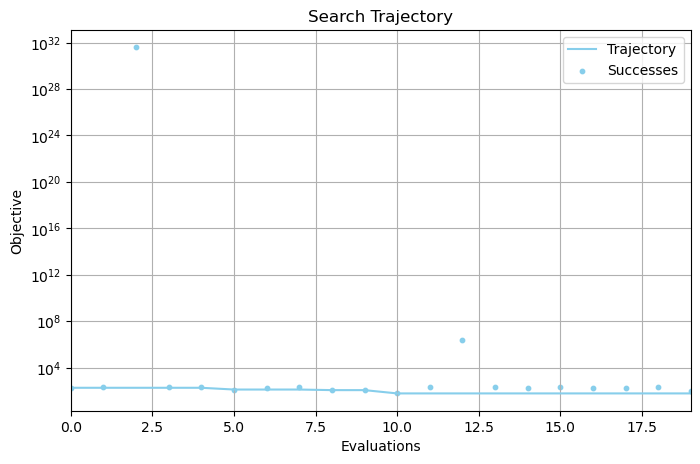

In [13]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo


WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

fig, ax = plt.subplots(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_search_trajectory_single_objective_hpo(reuslts, mode="min", ax=ax)
_ = plt.title("Search Trajectory")
_ = plt.yscale("log")